# NLP文本分类问题
0. [读取数据](#ch1)
0. [数据预处理](#ch2)
0. [建模](#ch3)
0. [预测和可视化](#ch4)
>总体思路是：1.将文本转化为词向量 2.词向量喂入模型。
如何转换？1.open(glove.txt)作为embeding索引，应为字典格式。2.Glove基于字词级别的分词，调用keras的tokenizer，进行fit文本，这步主要为了得到字词的word_index

>一般多少词有多少特征，可以建立max_feature(可以自己设置) x 300d的全0矩阵，遍历word_index，查找单词是否出现在一开始读入的embedding索引中，存在就get(word）获得词向量填充到矩阵对应行中。

>建模阶段：使用了双向LSTM模型，设置了两层LSTM，最后一层只输出一个值。(现在感觉加入一维卷积后输入的向量很奇怪，RNN不是每个cell都有输入了？TODO)

>结果其实有点过拟合，可以加入LN层标准化，或者增加Batch的大小。
分类采用的F1分数，也就是精确率和召回率的平均分数最为判断哪一类的门槛。算出来最佳是0.3

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split

<a id='ch1'></a>
##  0.读取数据、读取语料库

### 解压数据

In [2]:
# Extract a zip file
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip', 'r')
print(zip_ref.namelist())
embeddings = zip_ref.open('glove.840B.300d/glove.840B.300d.txt', 'r')

['GoogleNews-vectors-negative300/', 'glove.840B.300d/', 'paragram_300_sl999/', 'wiki-news-300d-1M/', 'glove.840B.300d/glove.840B.300d.txt', 'GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', 'wiki-news-300d-1M/wiki-news-300d-1M.vec', 'paragram_300_sl999/README.txt', 'paragram_300_sl999/paragram_300_sl999.txt']


### 读取语料库

In [3]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.decode().split(" ")) for o in embeddings)

### 读取数据

In [5]:
train_data = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
test_data = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')
print('训练集维度：\n',train_data.shape)
print('测试集维度：\n',test_data.shape)
train_data.sample(5)

训练集维度：
 (1306122, 3)
测试集维度：
 (375806, 2)


,qid,question_text,target
1200792,eb5717caf806173551c6,Where can I find carpet cleaners in Bromley?,0
709825,8af5f40cc2ef6fe77256,Which research labs at Westminster College are...,0
1048754,cd7fffa7b8695e43248b,Is it fair for someone has never worked in an ...,0
1093378,d6482453d336005407b3,What will be the most embarrassing question fo...,0
35751,06ff7165ce4c549a8f00,How is Canada as a country? Is it a good optio...,0


In [6]:
#将数据转化为列表
train_input = list(train_data['question_text'])
train_label = list(train_data['target'])

test_input = list(test_data['question_text'])

<a id='ch2'></a>
## 1.数据预处理
    1.1 转换大小写:  lower()
    1.2 分词tokenizer:  from tensorflow.keras.preprocessing.text import Tokenizer
    1.3 用空格代替停顿等无语语气词
    1.4 POS标注词性
    1.5 词干提取(stemming)和时态转换(lemmatization)
    1.6 对句子长度进行限定

#### 1.2用空格代替语气等无用词

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english') #调用英语语气词库

def remove_stop_words(x):
    for word in stop:
        token = " " + word + " "
        x.lower()    #将x转为小写
        if (x.find(token) != -1): #若没找到 返回-1
            x = x.replace(token, " ")
    return x

train_input_rsw = list(map(remove_stop_words, train_input))
test_input_rsw = list(map(remove_stop_words, test_input))

In [26]:
max_features=100000 #最大特征
embed_size = 300 # 词向量维度(语料库是300d)
max_length = 60 #最长句子长度（即RNN中隐层的长度）

#### 1.3 and 1.1 分词，并通过语料库提取嵌入矩阵

In [11]:
tokenizer=Tokenizer(num_words=max_features)
#num_words:None或整数,处理的最大单词数量。少于此数的单词丢掉
tokenizer.fit_on_texts(train_input_rsw)
#使用一系列文档来生成token词典，texts为list类，每个元素为一个文档。
word_index = tokenizer.word_index
n_words = min(max_features,len(word_index))

embedding_matrix = np.zeros((n_words+1, 300))

for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

#### 1.6 将文本转换为数字，并对其进行填充处理

In [27]:
sequences = tokenizer.texts_to_sequences(train_input_rsw)
#将多个文档转换为word下标的向量形式,shape为[len(texts)，len(text)] -- (文档数，每条文档的长度)
train_input_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print(train_input_padded.shape)

sequences = tokenizer.texts_to_sequences(test_input_rsw)
test_input_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print(test_input_padded.shape)

(1306122, 60)
(375806, 60)


In [29]:
train_input_padded[0]

array([   3, 6659, 7198,   94, 6082, 1149, 8316,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

## 切分训练集和测试集

In [45]:
 #shuffling the data
#np.random.seed(2)
#trn_idx = np.random.permutation(len(train_data))

#train_X = train_input_padded[trn_idx]
#train_y = train_data['target'][trn_idx] 

train_text, cv_text, train_target, cv_target = train_test_split(train_input_padded, train_label, test_size = 0.1, random_state=2)

<a id='ch3'></a>
##  2.Keras 建模
    模型基本结构为：嵌入层+双向LSTM层+Dropout层+一维卷积层+最大池化层+LSTM层+Dropout层+全连接层(sigmoid)

In [62]:
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,LSTM,Dropout,Conv1D,MaxPooling1D,Dense

In [63]:
lstm = Sequential()
lstm.add(Embedding(n_words+1,300, input_length=max_length, weights=[embedding_matrix], trainable=False))
lstm.add(Bidirectional(LSTM(256, return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Conv1D(100, 5, activation='relu'))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128))
lstm.add(Dropout(0.4))
lstm.add(Dense(1, activation='sigmoid'))

lstm.summary()

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 300)           30000300  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 512)           1140736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 100)           256100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [66]:
del embeddings_index
import gc
gc.collect()

51

In [67]:
history = lstm.fit(np.array(train_text), np.array(train_target), epochs = 5, validation_data=(np.array(cv_text),np.array(cv_target)), batch_size=512,verbose=1)

Epoch 1/5
2296/2296 [==============================] - 173s 75ms/step - loss: 0.1049 - acc: 0.9584 - val_loss: 0.1027 - val_acc: 0.9590
Epoch 2/5
2296/2296 [==============================] - 171s 75ms/step - loss: 0.0978 - acc: 0.9611 - val_loss: 0.1027 - val_acc: 0.9594
Epoch 3/5
2296/2296 [==============================] - 171s 75ms/step - loss: 0.0902 - acc: 0.9638 - val_loss: 0.1023 - val_acc: 0.9592
Epoch 4/5
2296/2296 [==============================] - 172s 75ms/step - loss: 0.0812 - acc: 0.9673 - val_loss: 0.1073 - val_acc: 0.9582
Epoch 5/5
2296/2296 [==============================] - 172s 75ms/step - loss: 0.0712 - acc: 0.9717 - val_loss: 0.1158 - val_acc: 0.9574


<a id='ch4'></a>
## 3.预测和可视化

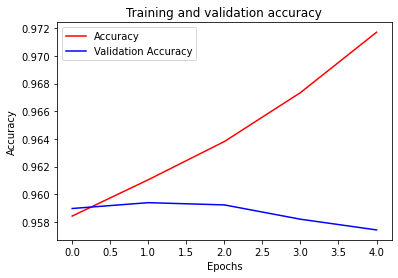

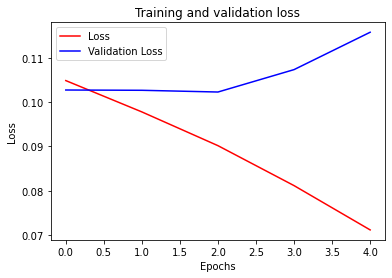

In [68]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(5)
##精确率图像
plt.figure()
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()
##损失图像
plt.figure()
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

#### 可以看出有些过拟合，可以dropput多些，最大特征设置的大些？模型参数也可以调一下

### 预测（f1分数）

In [70]:
from sklearn.metrics import f1_score
cv_predictions = lstm.predict(cv_text, batch_size=512)

thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    result = f1_score(cv_target, (cv_predictions>thresh).astype(int))
    thresholds.append([thresh, result])
    print("F1 score at threshold {} is {}".format(thresh, result))

thresholds.sort(key=lambda x: x[1], reverse=True)
print("Best value {}".format(thresholds[0]))
best_thresh = thresholds[0]

F1 score at threshold 0.1 is 0.6273899294575529
F1 score at threshold 0.11 is 0.6318757419865454
F1 score at threshold 0.12 is 0.6351703406813627
F1 score at threshold 0.13 is 0.6386171237390379
F1 score at threshold 0.14 is 0.6419220699214538
F1 score at threshold 0.15 is 0.6436984382296477
F1 score at threshold 0.16 is 0.645103795344936
F1 score at threshold 0.17 is 0.6472550161469639
F1 score at threshold 0.18 is 0.647854203409759
F1 score at threshold 0.19 is 0.6494767504585177
F1 score at threshold 0.2 is 0.6501332463153314
F1 score at threshold 0.21 is 0.651017386058246
F1 score at threshold 0.22 is 0.6511627906976744
F1 score at threshold 0.23 is 0.6521521242830893
F1 score at threshold 0.24 is 0.6527863516471182
F1 score at threshold 0.25 is 0.6531419529837251
F1 score at threshold 0.26 is 0.6530054644808743
F1 score at threshold 0.27 is 0.6523634694814135
F1 score at threshold 0.28 is 0.652867715078631
F1 score at threshold 0.29 is 0.6534791715150106
F1 score at threshold 0.3 

In [82]:
predictions = lstm.predict(cv_text)
predictions = np.around(predictions).astype(int)
df = pd.DataFrame({'pred': predictions.flatten(), 'actual': cv_target})
df.head()
pd.crosstab(df['pred'], df['actual'], margins=True)

actual,0,1,All
pred,,,
0,120333,3241,123574
1,2319,4720,7039
All,122652,7961,130613


In [90]:
predictions = lstm.predict(test_input_padded)

In [ ]:
predictions1 = (predictions>best_thresh).astype(int)
submission = pd.DataFrame({'qid': test_data.qid, 'prediction': predictions1[:,0]})
submission.to_csv('submission.csv', index=False)

![Cov1d](../photo/conv1d.jpg)

[https://www.zhihu.com/question/41949741]


https://blog.csdn.net/ssswill/article/details/88429794?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1.control